In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

import cv2

from unet import UNet
import scipy.optimize as optimize
from scipy.optimize import curve_fit

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_K2_5um_front_3M_100keV.txt"

In [ ]:
# Read a new dataset.
df = emsim_utils.read_electron_data(datfile,nevts=200005)
df.to_pickle("EM_5um_front_3M_100keV.pkl")

# Generate random multi-electron events

In [2]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

Created dataset for events from 0 to 198917


In [3]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [ ]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 100):
    
    A = fit_img/np.max(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1.0 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-3*nrows/ncols,nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh = 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

In [ ]:
# Create some number of events and count them.
th_unet = 0.9
th_classical = 825
evts = np.arange(0,10000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    label = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    ct_classical = (frame > th_classical)
    
    l_frames.append(frame)
    l_labels.append(label)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

In [ ]:
raw_th = 0.994
ct_th = 0.2
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

In [ ]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_label,b_label))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_label,b_label))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
plt.title("Classical counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
#plt.plot(bcenters_frame,hdist_frame,color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical')
plt.xlim([-5,5])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [26]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_frames_20x20_noise683_2e_bcsloss_front_100kev_89_withline.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=8)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if model.n_classes > 1 else 'max', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 198917


In [8]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train_unet(model, epoch, train_loader, optimizer)

Epoch:  0


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/1000 (0%)]	Loss: 0.001207	 score_max: 5.028306	 score_min: -25.362034; Accuracy 0.992
Train Epoch: 0 [50/1000 (5%)]	Loss: 0.001300	 score_max: 5.029306	 score_min: -26.824331; Accuracy 0.994
Train Epoch: 0 [100/1000 (10%)]	Loss: 0.000785	 score_max: 5.029420	 score_min: -28.461962; Accuracy 0.997
Train Epoch: 0 [150/1000 (15%)]	Loss: 0.001119	 score_max: 5.029015	 score_min: -27.895882; Accuracy 0.996
Train Epoch: 0 [200/1000 (20%)]	Loss: 0.001008	 score_max: 5.028013	 score_min: -26.641562; Accuracy 0.993
Train Epoch: 0 [250/1000 (25%)]	Loss: 0.000610	 score_max: 5.027302	 score_min: -25.351765; Accuracy 0.995
Train Epoch: 0 [300/1000 (30%)]	Loss: 0.000839	 score_max: 5.026938	 score_min: -27.388641; Accuracy 0.995
Train Epoch: 0 [350/1000 (35%)]	Loss: 0.000734	 score_max: 5.026937	 score_min: -27.644152; Accuracy 0.995
Train Epoch: 0 [400/1000 (40%)]	Loss: 0.000920	 score_max: 5.027208	 score_min: -27.375883; Accuracy 0.995
Train Epoch: 0 [450/1000 (45%)]	Loss: 0.00

Train Epoch: 3 [800/1000 (80%)]	Loss: 0.000663	 score_max: 5.053388	 score_min: -32.544308; Accuracy 0.993
Train Epoch: 3 [850/1000 (85%)]	Loss: 0.000283	 score_max: 5.053575	 score_min: -34.286663; Accuracy 0.996
Train Epoch: 3 [900/1000 (90%)]	Loss: 0.000482	 score_max: 5.053817	 score_min: -32.560051; Accuracy 0.994
Train Epoch: 3 [950/1000 (95%)]	Loss: 0.000261	 score_max: 5.054166	 score_min: -36.426434; Accuracy 0.997
---EPOCH AVG TRAIN LOSS: 0.0005207625996263232 ACCURACY: 0.995007473230362
Epoch:  4
Train Epoch: 4 [0/1000 (0%)]	Loss: 0.000837	 score_max: 5.054474	 score_min: -30.555470; Accuracy 0.992
Train Epoch: 4 [50/1000 (5%)]	Loss: 0.000288	 score_max: 5.054994	 score_min: -34.470612; Accuracy 0.996
Train Epoch: 4 [100/1000 (10%)]	Loss: 0.000340	 score_max: 5.055526	 score_min: -32.212456; Accuracy 0.993
Train Epoch: 4 [150/1000 (15%)]	Loss: 0.000614	 score_max: 5.056039	 score_min: -33.460197; Accuracy 0.993
Train Epoch: 4 [200/1000 (20%)]	Loss: 0.000561	 score_max: 5.056

Train Epoch: 7 [500/1000 (50%)]	Loss: 0.000493	 score_max: 5.077816	 score_min: -36.098362; Accuracy 0.996
Train Epoch: 7 [550/1000 (55%)]	Loss: 0.000565	 score_max: 5.078137	 score_min: -36.178638; Accuracy 0.995
Train Epoch: 7 [600/1000 (60%)]	Loss: 0.000554	 score_max: 5.078421	 score_min: -33.638596; Accuracy 0.992
Train Epoch: 7 [650/1000 (65%)]	Loss: 0.000492	 score_max: 5.078781	 score_min: -33.580627; Accuracy 0.995
Train Epoch: 7 [700/1000 (70%)]	Loss: 0.000458	 score_max: 5.079170	 score_min: -38.131027; Accuracy 0.996
Train Epoch: 7 [750/1000 (75%)]	Loss: 0.000576	 score_max: 5.079634	 score_min: -36.827057; Accuracy 0.996
Train Epoch: 7 [800/1000 (80%)]	Loss: 0.000266	 score_max: 5.079936	 score_min: -37.322361; Accuracy 0.995
Train Epoch: 7 [850/1000 (85%)]	Loss: 0.000360	 score_max: 5.080308	 score_min: -41.123829; Accuracy 0.995
Train Epoch: 7 [900/1000 (90%)]	Loss: 0.000405	 score_max: 5.080571	 score_min: -37.904858; Accuracy 0.995
Train Epoch: 7 [950/1000 (95%)]	Loss:

Train Epoch: 11 [300/1000 (30%)]	Loss: 0.000410	 score_max: 5.101601	 score_min: -37.886024; Accuracy 0.994
Train Epoch: 11 [350/1000 (35%)]	Loss: 0.000419	 score_max: 5.101736	 score_min: -36.599136; Accuracy 0.995
Train Epoch: 11 [400/1000 (40%)]	Loss: 0.000459	 score_max: 5.101788	 score_min: -39.505611; Accuracy 0.994
Train Epoch: 11 [450/1000 (45%)]	Loss: 0.000366	 score_max: 5.101768	 score_min: -39.490364; Accuracy 0.996
Train Epoch: 11 [500/1000 (50%)]	Loss: 0.000358	 score_max: 5.101866	 score_min: -41.539890; Accuracy 0.996
Train Epoch: 11 [550/1000 (55%)]	Loss: 0.000394	 score_max: 5.102068	 score_min: -43.302406; Accuracy 0.997
Train Epoch: 11 [600/1000 (60%)]	Loss: 0.000404	 score_max: 5.102402	 score_min: -43.054356; Accuracy 0.996
Train Epoch: 11 [650/1000 (65%)]	Loss: 0.000349	 score_max: 5.102857	 score_min: -39.930416; Accuracy 0.995
Train Epoch: 11 [700/1000 (70%)]	Loss: 0.000616	 score_max: 5.103263	 score_min: -37.571205; Accuracy 0.993
Train Epoch: 11 [750/1000 (7

Train Epoch: 15 [0/1000 (0%)]	Loss: 0.000667	 score_max: 5.123291	 score_min: -37.497112; Accuracy 0.993
Train Epoch: 15 [50/1000 (5%)]	Loss: 0.000659	 score_max: 5.123585	 score_min: -41.835796; Accuracy 0.995
Train Epoch: 15 [100/1000 (10%)]	Loss: 0.000408	 score_max: 5.123632	 score_min: -39.637974; Accuracy 0.995
Train Epoch: 15 [150/1000 (15%)]	Loss: 0.000229	 score_max: 5.123764	 score_min: -45.318626; Accuracy 0.997
Train Epoch: 15 [200/1000 (20%)]	Loss: 0.000374	 score_max: 5.123889	 score_min: -37.238453; Accuracy 0.994
Train Epoch: 15 [250/1000 (25%)]	Loss: 0.000547	 score_max: 5.124061	 score_min: -44.499298; Accuracy 0.996
Train Epoch: 15 [300/1000 (30%)]	Loss: 0.000387	 score_max: 5.124194	 score_min: -41.030243; Accuracy 0.995
Train Epoch: 15 [350/1000 (35%)]	Loss: 0.000386	 score_max: 5.124288	 score_min: -33.050453; Accuracy 0.994
Train Epoch: 15 [400/1000 (40%)]	Loss: 0.000179	 score_max: 5.124539	 score_min: -42.022049; Accuracy 0.995
Train Epoch: 15 [450/1000 (45%)]	

Train Epoch: 18 [800/1000 (80%)]	Loss: 0.000525	 score_max: 5.144016	 score_min: -36.906841; Accuracy 0.995
Train Epoch: 18 [850/1000 (85%)]	Loss: 0.000380	 score_max: 5.144485	 score_min: -45.406277; Accuracy 0.995
Train Epoch: 18 [900/1000 (90%)]	Loss: 0.000440	 score_max: 5.144991	 score_min: -43.314991; Accuracy 0.995
Train Epoch: 18 [950/1000 (95%)]	Loss: 0.000389	 score_max: 5.145405	 score_min: -44.125477; Accuracy 0.996
---EPOCH AVG TRAIN LOSS: 0.00043800699058920144 ACCURACY: 0.994929975271225
Epoch:  19
Train Epoch: 19 [0/1000 (0%)]	Loss: 0.000347	 score_max: 5.145844	 score_min: -42.460930; Accuracy 0.995
Train Epoch: 19 [50/1000 (5%)]	Loss: 0.000452	 score_max: 5.146309	 score_min: -41.845699; Accuracy 0.995
Train Epoch: 19 [100/1000 (10%)]	Loss: 0.000279	 score_max: 5.146629	 score_min: -44.603458; Accuracy 0.996
Train Epoch: 19 [150/1000 (15%)]	Loss: 0.000281	 score_max: 5.146858	 score_min: -45.904751; Accuracy 0.997
Train Epoch: 19 [200/1000 (20%)]	Loss: 0.000492	 score

Train Epoch: 22 [800/1000 (80%)]	Loss: 0.000316	 score_max: 5.167981	 score_min: -43.221043; Accuracy 0.995
Train Epoch: 22 [850/1000 (85%)]	Loss: 0.000366	 score_max: 5.168072	 score_min: -43.703804; Accuracy 0.994
Train Epoch: 22 [900/1000 (90%)]	Loss: 0.000195	 score_max: 5.168270	 score_min: -48.417908; Accuracy 0.997
Train Epoch: 22 [950/1000 (95%)]	Loss: 0.000289	 score_max: 5.168478	 score_min: -43.181198; Accuracy 0.993
---EPOCH AVG TRAIN LOSS: 0.00036492713625193576 ACCURACY: 0.9939699769020081
Epoch:  23
Train Epoch: 23 [0/1000 (0%)]	Loss: 0.000471	 score_max: 5.168759	 score_min: -41.219635; Accuracy 0.993
Train Epoch: 23 [50/1000 (5%)]	Loss: 0.000224	 score_max: 5.169182	 score_min: -39.632957; Accuracy 0.993
Train Epoch: 23 [100/1000 (10%)]	Loss: 0.000358	 score_max: 5.169531	 score_min: -43.542717; Accuracy 0.996
Train Epoch: 23 [150/1000 (15%)]	Loss: 0.000217	 score_max: 5.169827	 score_min: -45.934868; Accuracy 0.996
Train Epoch: 23 [200/1000 (20%)]	Loss: 0.000309	 scor

Train Epoch: 26 [800/1000 (80%)]	Loss: 0.000262	 score_max: 5.194111	 score_min: -48.637417; Accuracy 0.994
Train Epoch: 26 [850/1000 (85%)]	Loss: 0.000244	 score_max: 5.194605	 score_min: -47.842384; Accuracy 0.995
Train Epoch: 26 [900/1000 (90%)]	Loss: 0.000290	 score_max: 5.195031	 score_min: -46.278152; Accuracy 0.994
Train Epoch: 26 [950/1000 (95%)]	Loss: 0.000478	 score_max: 5.195375	 score_min: -40.829124; Accuracy 0.994
---EPOCH AVG TRAIN LOSS: 0.00041612302302382884 ACCURACY: 0.9944574773311615
Epoch:  27
Train Epoch: 27 [0/1000 (0%)]	Loss: 0.000518	 score_max: 5.195709	 score_min: -44.249195; Accuracy 0.995
Train Epoch: 27 [50/1000 (5%)]	Loss: 0.000550	 score_max: 5.195959	 score_min: -45.351471; Accuracy 0.996
Train Epoch: 27 [100/1000 (10%)]	Loss: 0.000564	 score_max: 5.196095	 score_min: -43.653873; Accuracy 0.993
Train Epoch: 27 [150/1000 (15%)]	Loss: 0.000257	 score_max: 5.196142	 score_min: -47.452484; Accuracy 0.998
Train Epoch: 27 [200/1000 (20%)]	Loss: 0.000578	 scor

Train Epoch: 30 [600/1000 (60%)]	Loss: 0.000204	 score_max: 5.214787	 score_min: -47.614388; Accuracy 0.995
Train Epoch: 30 [650/1000 (65%)]	Loss: 0.000663	 score_max: 5.215179	 score_min: -40.309769; Accuracy 0.995
Train Epoch: 30 [700/1000 (70%)]	Loss: 0.000134	 score_max: 5.215416	 score_min: -49.825211; Accuracy 0.996
Train Epoch: 30 [750/1000 (75%)]	Loss: 0.000447	 score_max: 5.215633	 score_min: -41.629040; Accuracy 0.992
Train Epoch: 30 [800/1000 (80%)]	Loss: 0.000338	 score_max: 5.215769	 score_min: -45.238514; Accuracy 0.994
Train Epoch: 30 [850/1000 (85%)]	Loss: 0.000356	 score_max: 5.215912	 score_min: -45.224167; Accuracy 0.994
Train Epoch: 30 [900/1000 (90%)]	Loss: 0.000847	 score_max: 5.216056	 score_min: -41.847893; Accuracy 0.993
Train Epoch: 30 [950/1000 (95%)]	Loss: 0.000565	 score_max: 5.215933	 score_min: -42.550938; Accuracy 0.994
---EPOCH AVG TRAIN LOSS: 0.00039003461060929114 ACCURACY: 0.9950724840164185
Epoch:  31
Train Epoch: 31 [0/1000 (0%)]	Loss: 0.000133	 sc

Train Epoch: 34 [350/1000 (35%)]	Loss: 0.000363	 score_max: 5.231538	 score_min: -46.952003; Accuracy 0.995
Train Epoch: 34 [400/1000 (40%)]	Loss: 0.000292	 score_max: 5.231856	 score_min: -44.209373; Accuracy 0.995
Train Epoch: 34 [450/1000 (45%)]	Loss: 0.000531	 score_max: 5.232072	 score_min: -49.700001; Accuracy 0.996
Train Epoch: 34 [500/1000 (50%)]	Loss: 0.000200	 score_max: 5.232419	 score_min: -53.298019; Accuracy 0.997
Train Epoch: 34 [550/1000 (55%)]	Loss: 0.000326	 score_max: 5.232751	 score_min: -47.488659; Accuracy 0.996
Train Epoch: 34 [600/1000 (60%)]	Loss: 0.000199	 score_max: 5.233083	 score_min: -46.996880; Accuracy 0.996
Train Epoch: 34 [650/1000 (65%)]	Loss: 0.000502	 score_max: 5.233329	 score_min: -42.323418; Accuracy 0.992
Train Epoch: 34 [700/1000 (70%)]	Loss: 0.000465	 score_max: 5.233603	 score_min: -43.675514; Accuracy 0.992
Train Epoch: 34 [750/1000 (75%)]	Loss: 0.000368	 score_max: 5.233991	 score_min: -44.279827; Accuracy 0.994
Train Epoch: 34 [800/1000 (8

Train Epoch: 38 [0/1000 (0%)]	Loss: 0.000476	 score_max: 5.252171	 score_min: -44.460785; Accuracy 0.995
Train Epoch: 38 [50/1000 (5%)]	Loss: 0.000338	 score_max: 5.252462	 score_min: -46.800980; Accuracy 0.995
Train Epoch: 38 [100/1000 (10%)]	Loss: 0.000315	 score_max: 5.252701	 score_min: -49.834595; Accuracy 0.996
Train Epoch: 38 [150/1000 (15%)]	Loss: 0.000668	 score_max: 5.252835	 score_min: -43.108852; Accuracy 0.992
Train Epoch: 38 [200/1000 (20%)]	Loss: 0.000465	 score_max: 5.252970	 score_min: -40.485840; Accuracy 0.992
Train Epoch: 38 [250/1000 (25%)]	Loss: 0.000160	 score_max: 5.253103	 score_min: -47.959389; Accuracy 0.995
Train Epoch: 38 [300/1000 (30%)]	Loss: 0.000462	 score_max: 5.253230	 score_min: -42.995750; Accuracy 0.995
Train Epoch: 38 [350/1000 (35%)]	Loss: 0.000567	 score_max: 5.253178	 score_min: -49.817768; Accuracy 0.995
Train Epoch: 38 [400/1000 (40%)]	Loss: 0.000550	 score_max: 5.253249	 score_min: -41.615944; Accuracy 0.992
Train Epoch: 38 [450/1000 (45%)]	

Train Epoch: 41 [800/1000 (80%)]	Loss: 0.000535	 score_max: 5.270255	 score_min: -43.964745; Accuracy 0.995
Train Epoch: 41 [850/1000 (85%)]	Loss: 0.000249	 score_max: 5.270422	 score_min: -47.068676; Accuracy 0.995
Train Epoch: 41 [900/1000 (90%)]	Loss: 0.000267	 score_max: 5.270569	 score_min: -39.521744; Accuracy 0.994
Train Epoch: 41 [950/1000 (95%)]	Loss: 0.000393	 score_max: 5.270741	 score_min: -47.273857; Accuracy 0.996
---EPOCH AVG TRAIN LOSS: 0.00043363645163481125 ACCURACY: 0.9947249740362167
Epoch:  42
Train Epoch: 42 [0/1000 (0%)]	Loss: 0.000373	 score_max: 5.270931	 score_min: -47.133961; Accuracy 0.996
Train Epoch: 42 [50/1000 (5%)]	Loss: 0.000242	 score_max: 5.271090	 score_min: -50.770378; Accuracy 0.995
Train Epoch: 42 [100/1000 (10%)]	Loss: 0.000420	 score_max: 5.271269	 score_min: -43.713097; Accuracy 0.996
Train Epoch: 42 [150/1000 (15%)]	Loss: 0.000527	 score_max: 5.271420	 score_min: -45.327480; Accuracy 0.993
Train Epoch: 42 [200/1000 (20%)]	Loss: 0.000159	 scor

Train Epoch: 45 [450/1000 (45%)]	Loss: 0.000642	 score_max: 5.286738	 score_min: -46.057404; Accuracy 0.992
Train Epoch: 45 [500/1000 (50%)]	Loss: 0.000279	 score_max: 5.287391	 score_min: -51.974579; Accuracy 0.994
Train Epoch: 45 [550/1000 (55%)]	Loss: 0.000796	 score_max: 5.288006	 score_min: -44.690933; Accuracy 0.994
Train Epoch: 45 [600/1000 (60%)]	Loss: 0.000586	 score_max: 5.288582	 score_min: -49.978680; Accuracy 0.995
Train Epoch: 45 [650/1000 (65%)]	Loss: 0.000670	 score_max: 5.288982	 score_min: -45.956306; Accuracy 0.995
Train Epoch: 45 [700/1000 (70%)]	Loss: 0.000112	 score_max: 5.289170	 score_min: -52.747704; Accuracy 0.997
Train Epoch: 45 [750/1000 (75%)]	Loss: 0.000605	 score_max: 5.289335	 score_min: -51.315327; Accuracy 0.996
Train Epoch: 45 [800/1000 (80%)]	Loss: 0.000368	 score_max: 5.289402	 score_min: -48.542065; Accuracy 0.994
Train Epoch: 45 [850/1000 (85%)]	Loss: 0.000216	 score_max: 5.289440	 score_min: -43.300095; Accuracy 0.994
Train Epoch: 45 [900/1000 (9

Train Epoch: 49 [100/1000 (10%)]	Loss: 0.000188	 score_max: 5.303148	 score_min: -55.495842; Accuracy 0.996
Train Epoch: 49 [150/1000 (15%)]	Loss: 0.000293	 score_max: 5.303560	 score_min: -48.078186; Accuracy 0.995
Train Epoch: 49 [200/1000 (20%)]	Loss: 0.000568	 score_max: 5.303880	 score_min: -50.227119; Accuracy 0.995
Train Epoch: 49 [250/1000 (25%)]	Loss: 0.000312	 score_max: 5.304054	 score_min: -43.346836; Accuracy 0.993
Train Epoch: 49 [300/1000 (30%)]	Loss: 0.000336	 score_max: 5.304221	 score_min: -50.700371; Accuracy 0.995
Train Epoch: 49 [350/1000 (35%)]	Loss: 0.000515	 score_max: 5.304462	 score_min: -48.546337; Accuracy 0.994
Train Epoch: 49 [400/1000 (40%)]	Loss: 0.000220	 score_max: 5.304576	 score_min: -53.565914; Accuracy 0.995
Train Epoch: 49 [450/1000 (45%)]	Loss: 0.000205	 score_max: 5.304708	 score_min: -50.884178; Accuracy 0.995
Train Epoch: 49 [500/1000 (50%)]	Loss: 0.000367	 score_max: 5.304808	 score_min: -50.502769; Accuracy 0.995
Train Epoch: 49 [550/1000 (5

Train Epoch: 52 [800/1000 (80%)]	Loss: 0.000606	 score_max: 5.320356	 score_min: -48.364155; Accuracy 0.995
Train Epoch: 52 [850/1000 (85%)]	Loss: 0.000451	 score_max: 5.320688	 score_min: -49.986153; Accuracy 0.996
Train Epoch: 52 [900/1000 (90%)]	Loss: 0.000343	 score_max: 5.321028	 score_min: -52.600170; Accuracy 0.996
Train Epoch: 52 [950/1000 (95%)]	Loss: 0.000186	 score_max: 5.321462	 score_min: -51.821907; Accuracy 0.996
---EPOCH AVG TRAIN LOSS: 0.00038075410557212306 ACCURACY: 0.9946074813604355
Epoch:  53
Train Epoch: 53 [0/1000 (0%)]	Loss: 0.000331	 score_max: 5.321810	 score_min: -51.404892; Accuracy 0.996
Train Epoch: 53 [50/1000 (5%)]	Loss: 0.000552	 score_max: 5.322045	 score_min: -45.318542; Accuracy 0.995
Train Epoch: 53 [100/1000 (10%)]	Loss: 0.000378	 score_max: 5.322261	 score_min: -49.657211; Accuracy 0.994
Train Epoch: 53 [150/1000 (15%)]	Loss: 0.000168	 score_max: 5.322533	 score_min: -57.180065; Accuracy 0.997
Train Epoch: 53 [200/1000 (20%)]	Loss: 0.000379	 scor

Train Epoch: 56 [450/1000 (45%)]	Loss: 0.000566	 score_max: 5.338515	 score_min: -52.754559; Accuracy 0.995
Train Epoch: 56 [500/1000 (50%)]	Loss: 0.000282	 score_max: 5.338765	 score_min: -54.632710; Accuracy 0.996
Train Epoch: 56 [550/1000 (55%)]	Loss: 0.000313	 score_max: 5.339074	 score_min: -56.970345; Accuracy 0.996
Train Epoch: 56 [600/1000 (60%)]	Loss: 0.000186	 score_max: 5.339362	 score_min: -47.278214; Accuracy 0.993
Train Epoch: 56 [650/1000 (65%)]	Loss: 0.000455	 score_max: 5.339671	 score_min: -51.808693; Accuracy 0.992
Train Epoch: 56 [700/1000 (70%)]	Loss: 0.000328	 score_max: 5.340167	 score_min: -52.424698; Accuracy 0.995
Train Epoch: 56 [750/1000 (75%)]	Loss: 0.000317	 score_max: 5.340655	 score_min: -48.476032; Accuracy 0.994
Train Epoch: 56 [800/1000 (80%)]	Loss: 0.000574	 score_max: 5.341044	 score_min: -50.721924; Accuracy 0.995
Train Epoch: 56 [850/1000 (85%)]	Loss: 0.000410	 score_max: 5.341283	 score_min: -55.301003; Accuracy 0.995
Train Epoch: 56 [900/1000 (9

Train Epoch: 60 [100/1000 (10%)]	Loss: 0.000309	 score_max: 5.355065	 score_min: -50.001060; Accuracy 0.996
Train Epoch: 60 [150/1000 (15%)]	Loss: 0.000342	 score_max: 5.355231	 score_min: -48.592705; Accuracy 0.994
Train Epoch: 60 [200/1000 (20%)]	Loss: 0.000415	 score_max: 5.355471	 score_min: -53.283569; Accuracy 0.996
Train Epoch: 60 [250/1000 (25%)]	Loss: 0.000352	 score_max: 5.355660	 score_min: -53.590096; Accuracy 0.995
Train Epoch: 60 [300/1000 (30%)]	Loss: 0.000333	 score_max: 5.355769	 score_min: -52.754520; Accuracy 0.995
Train Epoch: 60 [350/1000 (35%)]	Loss: 0.000370	 score_max: 5.355864	 score_min: -49.931374; Accuracy 0.994
Train Epoch: 60 [400/1000 (40%)]	Loss: 0.000229	 score_max: 5.355940	 score_min: -47.922958; Accuracy 0.997
Train Epoch: 60 [450/1000 (45%)]	Loss: 0.000256	 score_max: 5.355973	 score_min: -50.522911; Accuracy 0.994
Train Epoch: 60 [500/1000 (50%)]	Loss: 0.000359	 score_max: 5.356035	 score_min: -54.134727; Accuracy 0.995
Train Epoch: 60 [550/1000 (5

Train Epoch: 63 [800/1000 (80%)]	Loss: 0.000243	 score_max: 5.372028	 score_min: -54.481140; Accuracy 0.995
Train Epoch: 63 [850/1000 (85%)]	Loss: 0.000086	 score_max: 5.372062	 score_min: -62.027573; Accuracy 0.997
Train Epoch: 63 [900/1000 (90%)]	Loss: 0.000333	 score_max: 5.372128	 score_min: -56.769619; Accuracy 0.996
Train Epoch: 63 [950/1000 (95%)]	Loss: 0.000252	 score_max: 5.372334	 score_min: -51.985920; Accuracy 0.994
---EPOCH AVG TRAIN LOSS: 0.0003242869350287947 ACCURACY: 0.9946724742650985
Epoch:  64
Train Epoch: 64 [0/1000 (0%)]	Loss: 0.000193	 score_max: 5.372617	 score_min: -55.388832; Accuracy 0.996
Train Epoch: 64 [50/1000 (5%)]	Loss: 0.002053	 score_max: 5.372956	 score_min: -47.335609; Accuracy 0.991
Train Epoch: 64 [100/1000 (10%)]	Loss: 0.000363	 score_max: 5.373827	 score_min: -49.819756; Accuracy 0.995
Train Epoch: 64 [150/1000 (15%)]	Loss: 0.000361	 score_max: 5.374603	 score_min: -41.203995; Accuracy 0.994
Train Epoch: 64 [200/1000 (20%)]	Loss: 0.000287	 score

Train Epoch: 67 [650/1000 (65%)]	Loss: 0.000825	 score_max: 5.389714	 score_min: -49.804752; Accuracy 0.994
Train Epoch: 67 [700/1000 (70%)]	Loss: 0.000247	 score_max: 5.389711	 score_min: -55.202148; Accuracy 0.994
Train Epoch: 67 [750/1000 (75%)]	Loss: 0.000168	 score_max: 5.389755	 score_min: -53.635441; Accuracy 0.995
Train Epoch: 67 [800/1000 (80%)]	Loss: 0.000513	 score_max: 5.389800	 score_min: -45.037022; Accuracy 0.994
Train Epoch: 67 [850/1000 (85%)]	Loss: 0.000412	 score_max: 5.389865	 score_min: -47.972080; Accuracy 0.992
Train Epoch: 67 [900/1000 (90%)]	Loss: 0.000319	 score_max: 5.390031	 score_min: -53.512684; Accuracy 0.994
Train Epoch: 67 [950/1000 (95%)]	Loss: 0.000350	 score_max: 5.390188	 score_min: -52.501350; Accuracy 0.995
---EPOCH AVG TRAIN LOSS: 0.00036454597247939093 ACCURACY: 0.9945949673652649
Epoch:  68
Train Epoch: 68 [0/1000 (0%)]	Loss: 0.000416	 score_max: 5.390352	 score_min: -49.778275; Accuracy 0.994
Train Epoch: 68 [50/1000 (5%)]	Loss: 0.000387	 scor

Train Epoch: 71 [400/1000 (40%)]	Loss: 0.000354	 score_max: 5.406861	 score_min: -54.354919; Accuracy 0.995
Train Epoch: 71 [450/1000 (45%)]	Loss: 0.000238	 score_max: 5.407186	 score_min: -47.517380; Accuracy 0.994
Train Epoch: 71 [500/1000 (50%)]	Loss: 0.000341	 score_max: 5.407551	 score_min: -56.396217; Accuracy 0.995
Train Epoch: 71 [550/1000 (55%)]	Loss: 0.000155	 score_max: 5.407826	 score_min: -47.333210; Accuracy 0.994
Train Epoch: 71 [600/1000 (60%)]	Loss: 0.000450	 score_max: 5.408087	 score_min: -51.225266; Accuracy 0.995
Train Epoch: 71 [650/1000 (65%)]	Loss: 0.000639	 score_max: 5.408190	 score_min: -41.185913; Accuracy 0.992
Train Epoch: 71 [700/1000 (70%)]	Loss: 0.000540	 score_max: 5.408283	 score_min: -47.407146; Accuracy 0.993
Train Epoch: 71 [750/1000 (75%)]	Loss: 0.000247	 score_max: 5.408437	 score_min: -50.500538; Accuracy 0.994
Train Epoch: 71 [800/1000 (80%)]	Loss: 0.000148	 score_max: 5.408600	 score_min: -61.381111; Accuracy 0.998
Train Epoch: 71 [850/1000 (8

Train Epoch: 75 [150/1000 (15%)]	Loss: 0.000489	 score_max: 5.425667	 score_min: -48.680641; Accuracy 0.995
Train Epoch: 75 [200/1000 (20%)]	Loss: 0.000363	 score_max: 5.425709	 score_min: -62.883549; Accuracy 0.996
Train Epoch: 75 [250/1000 (25%)]	Loss: 0.000118	 score_max: 5.425728	 score_min: -62.756866; Accuracy 0.997
Train Epoch: 75 [300/1000 (30%)]	Loss: 0.000405	 score_max: 5.425727	 score_min: -54.967888; Accuracy 0.996
Train Epoch: 75 [350/1000 (35%)]	Loss: 0.000370	 score_max: 5.425650	 score_min: -49.771255; Accuracy 0.994
Train Epoch: 75 [400/1000 (40%)]	Loss: 0.000229	 score_max: 5.425471	 score_min: -41.405594; Accuracy 0.995
Train Epoch: 75 [450/1000 (45%)]	Loss: 0.000325	 score_max: 5.425270	 score_min: -56.383335; Accuracy 0.996
Train Epoch: 75 [500/1000 (50%)]	Loss: 0.000339	 score_max: 5.425145	 score_min: -50.363873; Accuracy 0.993
Train Epoch: 75 [550/1000 (55%)]	Loss: 0.000636	 score_max: 5.425146	 score_min: -46.603168; Accuracy 0.995
Train Epoch: 75 [600/1000 (6

Train Epoch: 78 [850/1000 (85%)]	Loss: 0.000515	 score_max: 5.437237	 score_min: -41.465591; Accuracy 0.992
Train Epoch: 78 [900/1000 (90%)]	Loss: 0.000214	 score_max: 5.437572	 score_min: -45.917000; Accuracy 0.993
Train Epoch: 78 [950/1000 (95%)]	Loss: 0.000179	 score_max: 5.437863	 score_min: -49.826099; Accuracy 0.996
---EPOCH AVG TRAIN LOSS: 0.00041339690797030925 ACCURACY: 0.9944374740123749
Epoch:  79
Train Epoch: 79 [0/1000 (0%)]	Loss: 0.000423	 score_max: 5.438154	 score_min: -50.060638; Accuracy 0.994
Train Epoch: 79 [50/1000 (5%)]	Loss: 0.000420	 score_max: 5.438342	 score_min: -47.036633; Accuracy 0.995
Train Epoch: 79 [100/1000 (10%)]	Loss: 0.000251	 score_max: 5.438539	 score_min: -50.735344; Accuracy 0.993
Train Epoch: 79 [150/1000 (15%)]	Loss: 0.000529	 score_max: 5.438820	 score_min: -52.852631; Accuracy 0.994
Train Epoch: 79 [200/1000 (20%)]	Loss: 0.000318	 score_max: 5.439105	 score_min: -48.798634; Accuracy 0.994
Train Epoch: 79 [250/1000 (25%)]	Loss: 0.000262	 scor

Train Epoch: 82 [500/1000 (50%)]	Loss: 0.000377	 score_max: 5.451046	 score_min: -56.782993; Accuracy 0.995
Train Epoch: 82 [550/1000 (55%)]	Loss: 0.000239	 score_max: 5.450942	 score_min: -54.124733; Accuracy 0.995
Train Epoch: 82 [600/1000 (60%)]	Loss: 0.000282	 score_max: 5.450964	 score_min: -52.384727; Accuracy 0.994
Train Epoch: 82 [650/1000 (65%)]	Loss: 0.000621	 score_max: 5.451042	 score_min: -51.074394; Accuracy 0.994
Train Epoch: 82 [700/1000 (70%)]	Loss: 0.000539	 score_max: 5.451327	 score_min: -57.399055; Accuracy 0.996
Train Epoch: 82 [750/1000 (75%)]	Loss: 0.000291	 score_max: 5.451721	 score_min: -50.079124; Accuracy 0.995
Train Epoch: 82 [800/1000 (80%)]	Loss: 0.000403	 score_max: 5.452129	 score_min: -48.500954; Accuracy 0.993
Train Epoch: 82 [850/1000 (85%)]	Loss: 0.000394	 score_max: 5.452609	 score_min: -60.174442; Accuracy 0.996
Train Epoch: 82 [900/1000 (90%)]	Loss: 0.000240	 score_max: 5.453119	 score_min: -57.491291; Accuracy 0.997
Train Epoch: 82 [950/1000 (9

Train Epoch: 86 [250/1000 (25%)]	Loss: 0.000338	 score_max: 5.466693	 score_min: -48.952900; Accuracy 0.992
Train Epoch: 86 [300/1000 (30%)]	Loss: 0.000089	 score_max: 5.467077	 score_min: -59.098732; Accuracy 0.996
Train Epoch: 86 [350/1000 (35%)]	Loss: 0.000339	 score_max: 5.467448	 score_min: -51.641621; Accuracy 0.994
Train Epoch: 86 [400/1000 (40%)]	Loss: 0.000337	 score_max: 5.467763	 score_min: -56.839542; Accuracy 0.996
Train Epoch: 86 [450/1000 (45%)]	Loss: 0.000224	 score_max: 5.468020	 score_min: -62.429806; Accuracy 0.997
Train Epoch: 86 [500/1000 (50%)]	Loss: 0.000120	 score_max: 5.468286	 score_min: -58.709084; Accuracy 0.994
Train Epoch: 86 [550/1000 (55%)]	Loss: 0.000192	 score_max: 5.468589	 score_min: -52.137829; Accuracy 0.994
Train Epoch: 86 [600/1000 (60%)]	Loss: 0.000280	 score_max: 5.468832	 score_min: -61.133644; Accuracy 0.996
Train Epoch: 86 [650/1000 (65%)]	Loss: 0.000111	 score_max: 5.468939	 score_min: -57.048927; Accuracy 0.996
Train Epoch: 86 [700/1000 (7

KeyboardInterrupt: 

In [9]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_front_100kev_{}.pt".format(modeldir,epoch))

#### Test the net

In [27]:
sigmoid = nn.Sigmoid()
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

Created dataset for events from 0 to 198917


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

In [32]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.logspace(-0.5,-0.001,1000)
classical_thresholds = np.arange(600,7000,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        pred = (evt_arr > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


Text(0, 0.5, 'True positive rate')

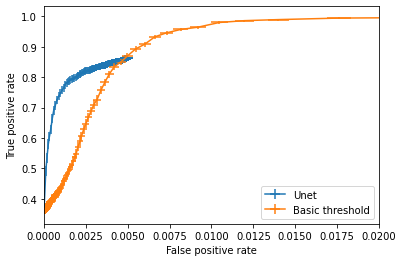

In [33]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [30]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

NN ------------------
[Threshold 0.9772372209558107] TP = 0.355, FP = 0.0
[Threshold 0.9772574929846057] TP = 0.355, FP = 0.0
[Threshold 0.9772777654339282] TP = 0.355, FP = 0.0
[Threshold 0.977298038303787] TP = 0.355, FP = 0.0
[Threshold 0.9773183115941908] TP = 0.355, FP = 0.0
[Threshold 0.9773385853051483] TP = 0.355, FP = 0.0
[Threshold 0.9773588594366681] TP = 0.355, FP = 0.0
[Threshold 0.9773791339887592] TP = 0.355, FP = 0.0
[Threshold 0.9773994089614301] TP = 0.355, FP = 0.0
[Threshold 0.9774196843546896] TP = 0.355, FP = 0.0
[Threshold 0.9774399601685464] TP = 0.355, FP = 0.0
[Threshold 0.9774602364030093] TP = 0.355, FP = 0.0
[Threshold 0.9774805130580869] TP = 0.355, FP = 0.0
[Threshold 0.977500790133788] TP = 0.355, FP = 0.0
[Threshold 0.9775210676301214] TP = 0.355, FP = 0.0
[Threshold 0.9775413455470957] TP = 0.355, FP = 0.0
[Threshold 0.9775616238847197] TP = 0.355, FP = 0.0
[Threshold 0.977581902643002] TP = 0.355, FP = 0.0
[Threshold 0.9776021818219515] TP = 0.355, FP

In [ ]:
evt_plt = 100001
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][0]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
outputs,labels = [], []
for iframe in range(500):
    frame,label = frameset[iframe]
    outputs.append(label[1])
    labels.append(label)
outputs = np.array(outputs)
labels = np.array(labels)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 2
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
iframe = 5
show_sum = True

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
plt.colorbar()
plt.title("LossW")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 74      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_10cells_noise_100k_74.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_10cells_noise_100k_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(80000,80100)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.02
sigma_cut = 1e9
plt.hist(df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN,alpha=0.8,bins=50,color='blue',label='NN error')
plt.hist(df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3,alpha=0.8,bins=50,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
plt.yscale('log')
plt.legend()

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 81001
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX + dset.add_shift*emnet.PIXEL_SIZE
ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))